In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta, time
from plotly.subplots import make_subplots

In [128]:
import plotly.io as pio
pio.renderers.default = "jupyterlab"

In [129]:
Trips = pd.read_csv('Tracking_Trips.csv')
actives = pd.read_csv('activetripsandreports.csv')

In [130]:
Trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38333 entries, 0 to 38332
Data columns (total 64 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          38333 non-null  int64  
 1   request_datetime            38333 non-null  object 
 2   driver_id                   32796 non-null  float64
 3   source_id                   38333 non-null  int64  
 4   accept_datetime             28076 non-null  object 
 5   assign_datetime             32796 non-null  object 
 6   state                       38333 non-null  int64  
 7   source_address              38306 non-null  object 
 8   source_location             38333 non-null  object 
 9   source_title                38333 non-null  object 
 10  source_phone                36898 non-null  object 
 11  requested_arrival_datetime  38333 non-null  object 
 12  seen_datetime               28414 non-null  object 
 13  cancel_datetime             649

In [131]:
actives.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44665 entries, 0 to 44664
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   44665 non-null  int64  
 1   datetime             44665 non-null  object 
 2   area_name            44665 non-null  object 
 3   zone_name            41496 non-null  object 
 4   trips_count          44665 non-null  int64  
 5   trip_ids             44665 non-null  object 
 6   drivers_count        44665 non-null  int64  
 7   driver_ids           44665 non-null  object 
 8   trips_minus_drivers  44665 non-null  int64  
 9   area_id              44665 non-null  int64  
 10  zone_id              41496 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 3.7+ MB


In [132]:
actives['datetime'] = pd.to_datetime(actives['datetime'])
Trips['request_datetime'] = pd.to_datetime(Trips['request_datetime'])
Trips['arrival_datetime'] = pd.to_datetime(Trips['arrival_datetime'])
Trips['assign_datetime'] = pd.to_datetime(Trips['assign_datetime'])
Trips['requested_arrival_datetime'] = pd.to_datetime(Trips['requested_arrival_datetime'])

In [133]:
Trips.drop(['source_phone', 'source_address', 'source_logo', 'aborted_for_delay', 'driver_tag'], axis=1, inplace=True)
Trips = Trips[Trips['cancel_datetime'].isnull()]
Trips = Trips[((Trips['request_datetime'].dt.date)>pd.to_datetime('20210717' , format='%Y%m%d'))].reset_index(drop=True) 
Trips.sort_values(by='request_datetime', inplace=True)

In [134]:
Trips['request_datetime'].min()

Timestamp('2021-07-24 03:45:16.776443+0430', tz='pytz.FixedOffset(270)')

In [135]:
Trips['request_datetime'].max()

Timestamp('2021-07-30 18:59:38.914131+0430', tz='pytz.FixedOffset(270)')

In [136]:
Trips['state'].unique()

array([50, 70])

In [137]:
Trips['arrival_time'] = np.ceil((Trips['arrival_datetime'] - Trips['request_datetime']).dt.seconds/60)
threshold = 15
Trips['expired'] = np.where(Trips['arrival_time']>threshold, True , False)

In [138]:
Trips['expired'].value_counts()

False    26567
True      5270
Name: expired, dtype: int64

In [139]:
def plot(trips , date):
    
    total_trips = trips[(trips['request_datetime'].dt.date == date)]\
                        .groupby(pd.Grouper(key='request_datetime', freq='15min'))['id'].count()\
                        .reset_index().rename({'id':'total'}, axis=1)
    
    expired_trips = trips[(trips['request_datetime'].dt.date == date) &
                          (trips['expired']==True)]\
                        .groupby(pd.Grouper(key='request_datetime', freq='15min'))['expired'].count().reset_index()

    not_expired_trips = trips[(trips['request_datetime'].dt.date == date) &
                          (trips['expired']==False)]\
                        .groupby(pd.Grouper(key='request_datetime', freq='15min'))['expired'].count()\
                        .reset_index().rename({'expired':'on_time'}, axis=1)
    
    assigned_trips = trips[(trips['request_datetime'].dt.date == date)]\
                        .groupby(pd.Grouper(key='assign_datetime', freq='15min'))['id'].nunique()\
                        .reset_index().rename({'id':'assigned'}, axis=1)
    
    total_trips = total_trips.merge(assigned_trips, left_on='request_datetime', right_on='assign_datetime', how='left')
    total_trips = total_trips.merge(expired_trips, on='request_datetime')
    total_trips = total_trips.merge(not_expired_trips, on='request_datetime')
    total_trips['expired_ratio'] = total_trips['expired'] / total_trips['total']

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Bar(
        x=total_trips['request_datetime'],
        y=total_trips['expired'],
        name='Expired Trips',
        marker_color='indianred'),
        secondary_y=False
    )

    fig.add_trace(go.Bar(
        x=total_trips['request_datetime'],
        y=total_trips['on_time'],
        name='On Time Trips',
        marker_color='lightsalmon'),
        secondary_y=False
    )

    fig.add_trace(go.Scatter(
        x=total_trips['request_datetime'],
        y=total_trips['expired_ratio'],
        name='Expired Trips Percentage',
        marker_color='black',
        mode='lines'),
        secondary_y=True
    )
    
    
    fig.add_trace(go.Scatter(
        x=total_trips['request_datetime'],
        y=total_trips['assigned'],
        name='Assigned Trips',
        marker_color='blue',
        mode='lines'),
        secondary_y= False
    )
    

    fig.update_xaxes(
        tickmode = 'array',
        tickvals =[total_trips['request_datetime'].loc[n] for n in range(0,total_trips.shape[0],6)],
        ticktext = [(total_trips['request_datetime'].loc[n]+timedelta(hours=4, minutes=30)).time()
                    for n in range(0,total_trips.shape[0],6)]
    )
    
    fig.update_yaxes(range=[0,1], secondary_y=True)
    fig.update_layout(barmode='relative', xaxis_tickangle=-45, title=date.strftime('%A'))
    fig.show()


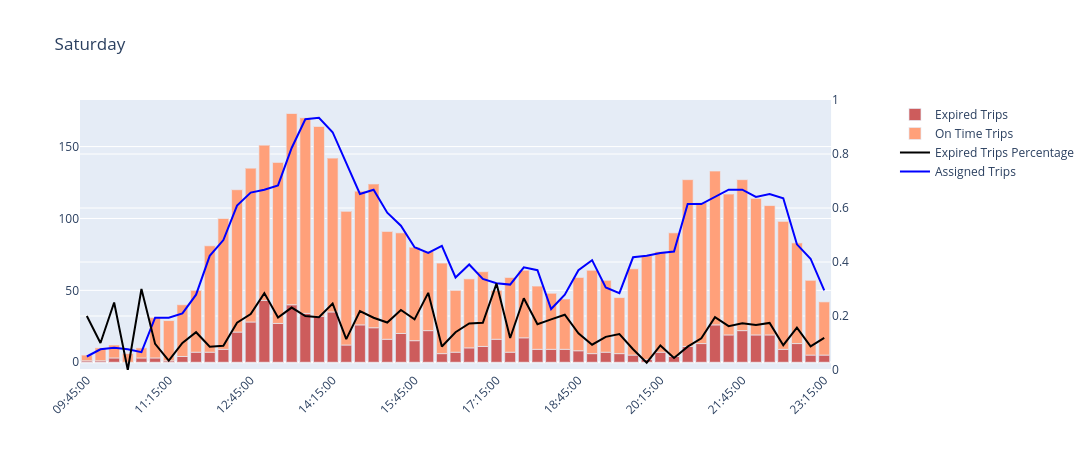

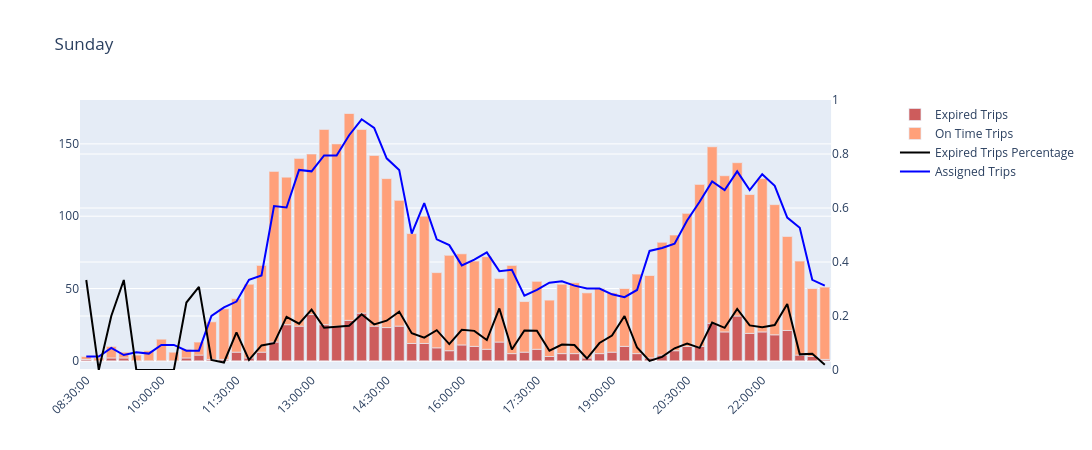

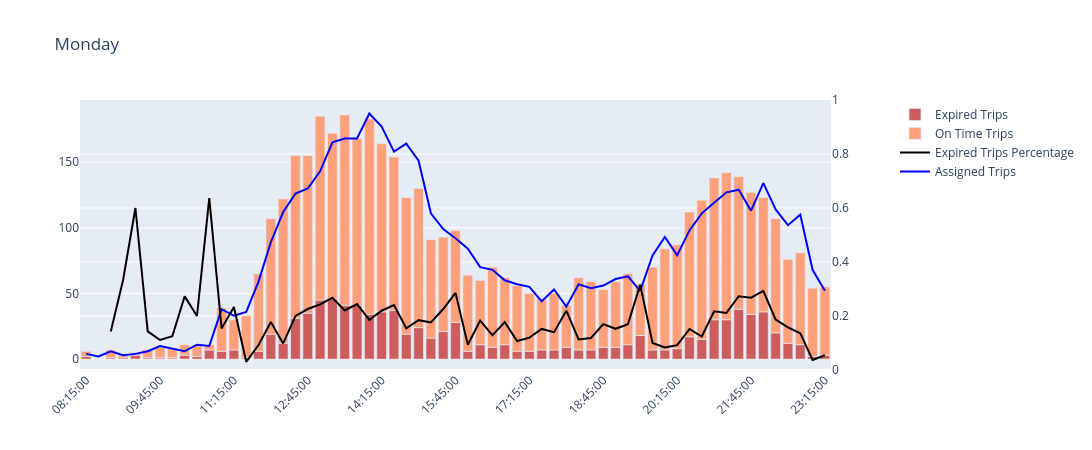

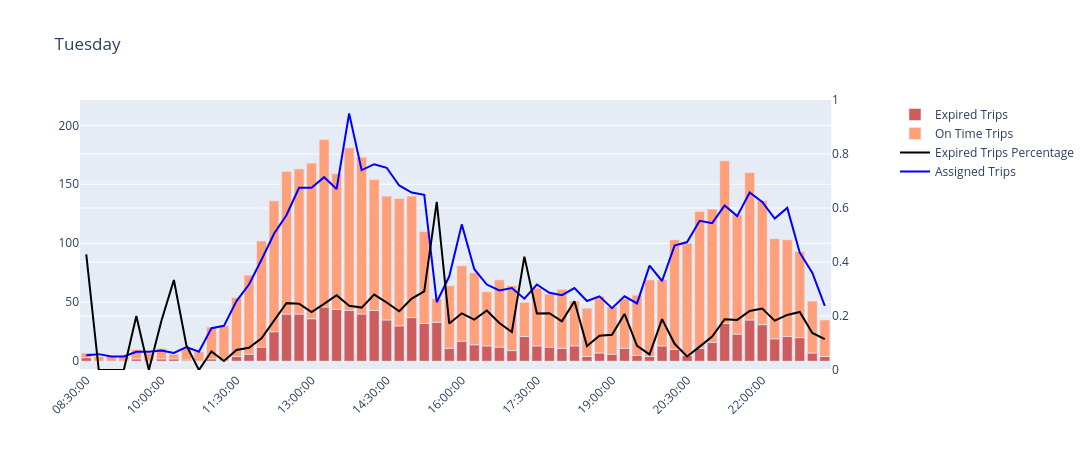

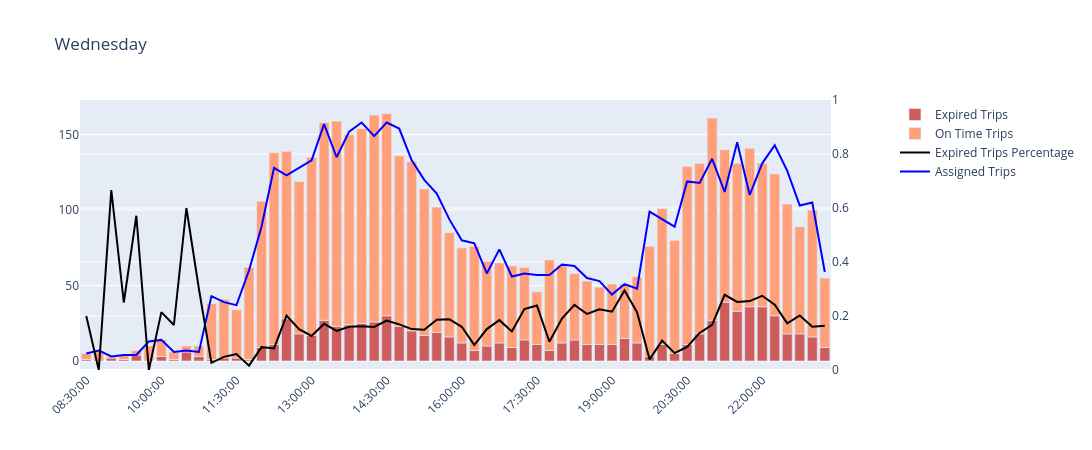

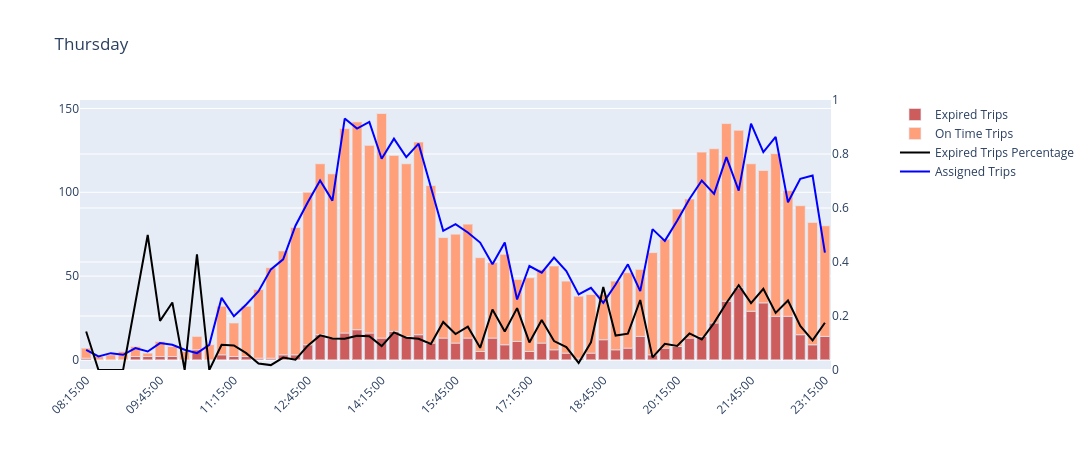

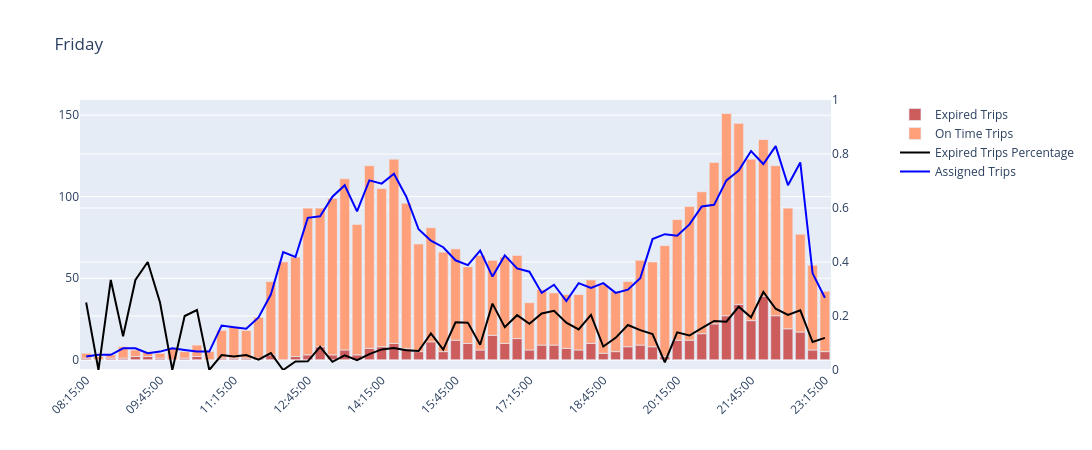

In [140]:
start_date = pd.to_datetime('20210724', format='%Y%m%d') 

for single_date in (start_date + timedelta(days=n) for n in range(7)):
    plot(Trips, single_date)
